In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate_hk_network(G, opinions, epsilon, steps):
    opinions = opinions.copy()
    history = [opinions.copy()]
    for _ in range(steps):
        new_opinions = opinions.copy()
        for i in G.nodes:
            neighbors = [j for j in G.neighbors(i) if abs(opinions[i] - opinions[j]) <= epsilon]
            if neighbors:
                neighbors.append(i)  # 自分も含めて平均を取る
                new_opinions[i] = np.mean([opinions[j] for j in neighbors])
        opinions = new_opinions
        history.append(opinions.copy())
    return np.array(history)

In [3]:
def simulate_dw_network(G, opinions, epsilon, mu, steps):
    opinions = opinions.copy()
    history = [opinions.copy()]
    for _ in range(steps):
        i = np.random.choice(G.nodes)
        neighbors = list(G.neighbors(i))
        if neighbors:
            j = np.random.choice(neighbors)
            if abs(opinions[i] - opinions[j]) <= epsilon:
                x_i, x_j = opinions[i], opinions[j]
                opinions[i] = x_i + mu * (x_j - x_i)
                opinions[j] = x_j + mu * (x_i - x_j)
        history.append(opinions.copy())
    return np.array(history)

- $\mu$ は意見変化の「速さ」と「度合い」を決定する
- $\mu=1$の時、相互作用した2つのエージェントの意見が完全に相手の意見に入れ替わる
    - モデルの挙動は非常に極端なものになる
- 通常、$\mu$ は $0 < \mu \le 0.5$ の範囲で設定される
    - $\mu$ が小さい場合 
        - 各エージェントは、相手の意見に対してわずかしか歩み寄りません
        - 意見の収束にはより多くの時間がかかる
    - $\mu$ が大きい場合
        - 各エージェントは、相手の意見に対して積極的に歩み寄り
        - $\mu = 0.5$ の場合は、相互作用した2つのエージェントの意見は完全に平均値に収束し、両者ともに中間的な立場を取る

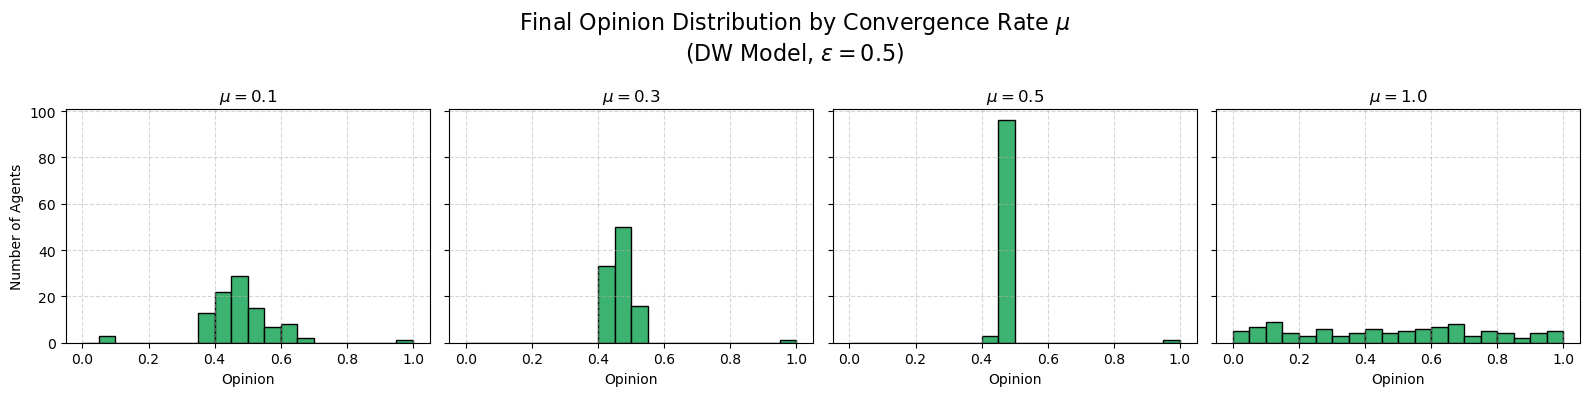

In [14]:
N = 100  # エージェント数
steps = 4000
epsilon = 0.5  # 意見の許容範囲（固定）
mu_values = [0.1, 0.3, 0.5, 1.0]  # 意見変化の速さ

# --- ネットワーク構造と初期意見の設定 ---
G = nx.watts_strogatz_graph(N, k=6, p=0.1)
np.random.seed(0)
initial_opinions = np.random.rand(N)

# --- シミュレーション実行 ---
dw_mu_results = {}
for mu_val in mu_values:
    dw_mu_results[mu_val] = simulate_dw_network(G, initial_opinions, epsilon, mu_val, steps)

    # --- 可視化 ---
fig, axs = plt.subplots(1, len(mu_values), figsize=(16, 4), sharey=True)
for idx, mu_val in enumerate(mu_values):
    final_opinions = dw_mu_results[mu_val][-1]
    axs[idx].hist(final_opinions, bins=20, range=(0, 1), color='mediumseagreen', edgecolor='black')
    axs[idx].set_title(f"$\\mu = {mu_val:.1f}$", fontsize=12)
    axs[idx].set_xlabel("Opinion")
    if idx == 0:
        axs[idx].set_ylabel("Number of Agents")
    axs[idx].grid(True, linestyle="--", alpha=0.5)

fig.suptitle("Final Opinion Distribution by Convergence Rate $\\mu$\n(DW Model, $\\epsilon=0.5$)", fontsize=16)
plt.tight_layout()
plt.show()

- $\epsilon$ が小さい場合: 自分とほとんど同じ意見を持つ相手としか相互作用し
    - 多数の非常に小さな意見のクラスターに分断する
- $\epsilon$ が大きい場合: 自分とかなり異なる意見を持つ相手でも、積極的に受け入れて相互作用する
    - 社会全体の意見は最終的に一つの意見に収束しやすい
    - (意見の範囲が$[0,1]である$)$\epsilon>0.5$の時、どのようなネットワークにおいても意見はならず$0.5$の周りに集中し、合意に達する
        - 最も離れた意見を持つエージェント同士ですら、最終的には相互作用の連鎖を通じてつながり、お互い影響を与え合うことができる

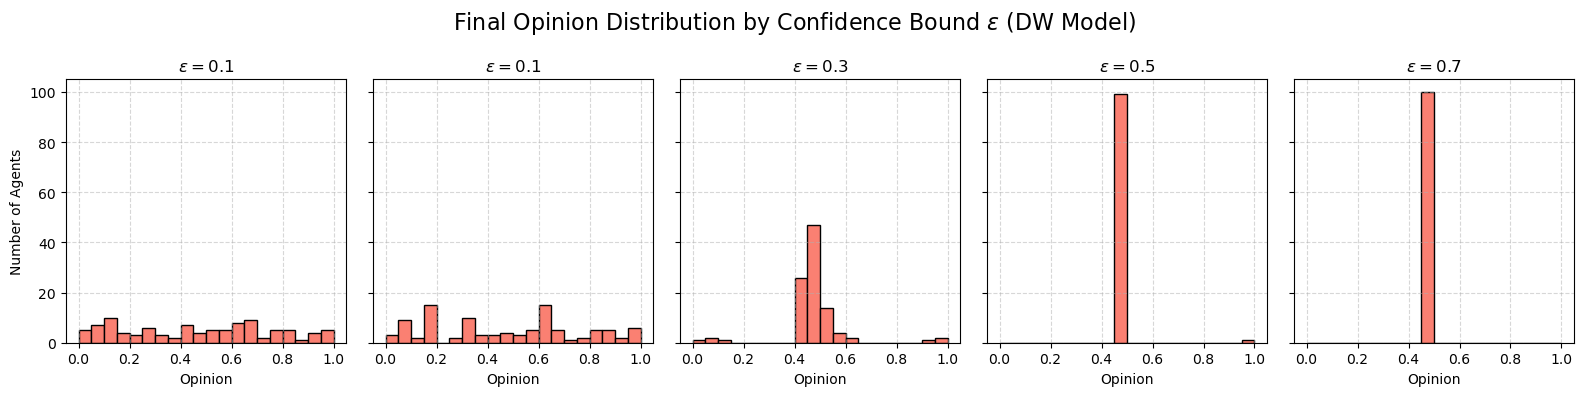

In [12]:
N = 100
steps = 4000
epsilons = [0.05, 0.1, 0.3, 0.5, 0.7]
mu = 0.5  # DWモデルの妥協度

# スモールワールドネットワーク
G = nx.watts_strogatz_graph(N, k=6, p=0.1)

# 初期意見
np.random.seed(0)
initial_opinions = np.random.rand(N)

# シミュレーション実行
dw_results = {}
for eps in epsilons:
    dw_results[eps] = simulate_dw_network(G, initial_opinions, eps, mu, steps)


# --- 可視化：最終意見のヒストグラム ---

fig, axs = plt.subplots(1, len(epsilons), figsize=(16, 4), sharey=True)
for idx, eps in enumerate(epsilons):
    final_opinions = dw_results[eps][-1]
    axs[idx].hist(final_opinions, bins=20, range=(0, 1), color='salmon', edgecolor='black')
    axs[idx].set_title(f"$\\epsilon = {eps:.1f}$", fontsize=12)
    axs[idx].set_xlabel("Opinion")
    if idx == 0:
        axs[idx].set_ylabel("Number of Agents")
    axs[idx].grid(True, linestyle="--", alpha=0.5)

fig.suptitle("Final Opinion Distribution by Confidence Bound $\\epsilon$ (DW Model)", fontsize=16)
plt.tight_layout()
plt.show()

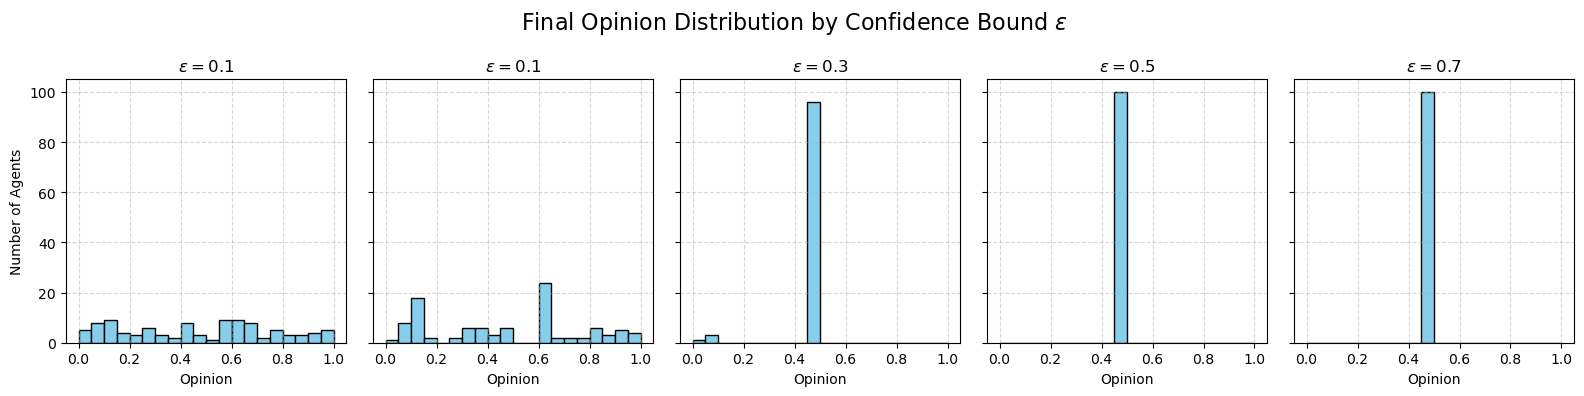

In [6]:
N = 100
steps = 300
epsilons = [0.05, 0.1, 0.3, 0.5, 0.7]

# スモールワールドネットワーク
G = nx.watts_strogatz_graph(N, k=6, p=0.1)

# 初期意見
np.random.seed(0)
initial_opinions = np.random.rand(N)

# シミュレーション実行
hk_results = {}
for eps in epsilons:
    hk_results[eps] = simulate_hk_network(G, initial_opinions, eps, steps)

# --- 可視化：最終意見のヒストグラム ---

fig, axs = plt.subplots(1, len(epsilons), figsize=(16, 4), sharey=True)
for idx, eps in enumerate(epsilons):
    final_opinions = hk_results[eps][-1]
    axs[idx].hist(final_opinions, bins=20, range=(0, 1), color='skyblue', edgecolor='black')
    axs[idx].set_title(f"$\\epsilon = {eps:.1f}$", fontsize=12)
    axs[idx].set_xlabel("Opinion")
    if idx == 0:
        axs[idx].set_ylabel("Number of Agents")
    axs[idx].grid(True, linestyle="--", alpha=0.5)

fig.suptitle("Final Opinion Distribution by Confidence Bound $\\epsilon$", fontsize=16)
plt.tight_layout()
plt.show()

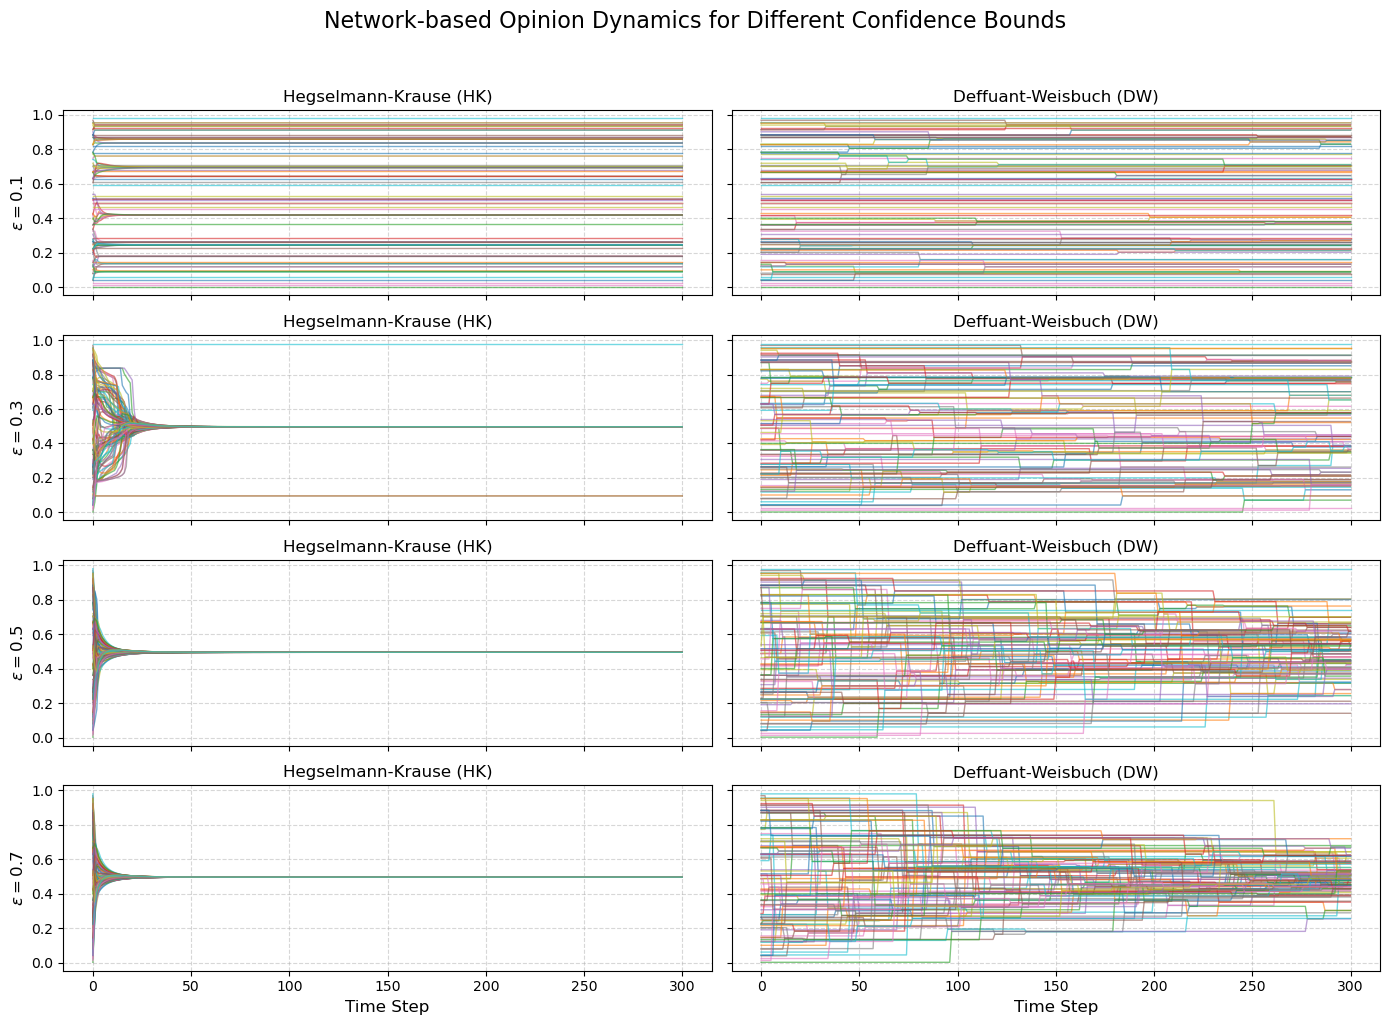

In [34]:
# シミュレーションパラメータ
N = 100
mu = 0.5
steps = 300
epsilons = [0.1, 0.3,0.5,0.7]

# ネットワーク構造：スモールワールドネットワーク
G = nx.watts_strogatz_graph(N, k=6, p=0.1)

# 初期意見（同じものを使いまわす）
initial_opinions = np.random.rand(N)
# 結果保存
hk_results = {}
dw_results = {}

# 各 epsilon でシミュレーション
for eps in epsilons:
    hk_results[eps] = simulate_hk_network(G, initial_opinions, eps, steps)
    dw_results[eps] = simulate_dw_network(G, initial_opinions, eps, mu, steps)

# 可視化
fig, axs = plt.subplots(len(epsilons), 2, figsize=(14, 10), sharex=True, sharey=True)

for idx, eps in enumerate(epsilons):
    for agent in range(N):
        axs[idx, 0].plot(hk_results[eps][:, agent], alpha=0.6, lw=1)
        axs[idx, 1].plot(dw_results[eps][:, agent], alpha=0.6, lw=1)

    axs[idx, 0].set_ylabel(f"$\epsilon = {eps:.1f}$", fontsize=12)
    axs[idx, 0].set_title("Hegselmann-Krause (HK)", fontsize=12)
    axs[idx, 1].set_title("Deffuant-Weisbuch (DW)", fontsize=12)

    axs[idx, 0].grid(True, linestyle="--", alpha=0.5)
    axs[idx, 1].grid(True, linestyle="--", alpha=0.5)

axs[-1, 0].set_xlabel("Time Step", fontsize=12)
axs[-1, 1].set_xlabel("Time Step", fontsize=12)

fig.suptitle("Network-based Opinion Dynamics for Different Confidence Bounds", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()